In [51]:
#! /usr/bin/env python
'''
    code for gaussian mixture solver
    based on Kalai STOC'10 paper
    Efficiently learning mixtures of two gaussians
'''
from __future__ import division
import numpy as np
import scipy as sp
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import mixture
import time
#from gmm_test import *
%matplotlib inline 

In [67]:
class TwoGaussian(object):
    def __init__(self, SAF):
        self.n = len(SAF)
        self.mu = np.mean(SAF)
        print "mu = {}".format(self.mu)
        self.sigma2 = np.var(SAF)
        sample = SAF - self.mu
        #sample = SAF
        self.M1 = np.mean(sample)
        self.M2 = np.mean(sample**2)
        self.M3 = np.mean(sample**3)
        self.M4 = np.mean(sample**4)
        self.M5 = np.mean(sample**5)
        self.M6 = np.mean(sample**6)
        self.x3 = self.M3
        self.x4 = self.M4 - 3* self.M2**2
        self.x5 = self.M5 - 10 * self.M3 * self.M2
        self.x6 = self.M6 - 15 * self.M4 * self.M2 + 30 * self.M2**3

        
    def recoverAlphaFromMoment(self, eps, xparam):
        X3, X4, X5, X6 = xparam
        coeff1 = [2, 0, X4, -X3**2]
        ymax = np.max(np.roots(coeff1))
        kai = 1. + np.sqrt(np.abs(X4))/ymax
        #remove 18th degree polynomial for reference in later session
        
        #only keep cofficients of the first derivative of r(y)
        #numpy roots
        #coeff2= self.rprime(X3, X4, X5, X6)
        #R = np.roots(coeff2)
        #numpy poly roots
        coeff2= (self.rprime(X3, X4, X5, X6))[::-1]
        R = np.polynomial.polynomial.polyroots(coeff2)
        print "R = {}".format(R)
        real_valued = R.real[abs(R.imag)<1e-5] # where I chose 1-e5 as a threshold
        #print real_valued
        #candidates = np.append(R, (1+eps/kai)*ymax)
        thred1 = (1+eps/kai)*ymax
        thred2 = (eps**2)*(kai**10)
        print "thred1 = {}".format(thred1)
        #candidates = np.append(real_valued, thred1)
        candidates = real_valued
        small_candidates = candidates[(candidates <= thred1)*(candidates > 0)]
        res = [x for x in small_candidates if self.ry(x) <= thred2*x**18]
        print "res = {}".format(res)
        #assert len(res) > 0, 'no valid solution for alpha'
        if len(res) > 0:
            print "greater than zero. "
            return np.max(res)
        else:
            print "max value = {}".format(np.max(small_candidates))
            return np.max(small_candidates)
    
    def recoverFromMoments(self, eps):
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        #mu = self.M1
        alpha = self.recoverAlphaFromMoment(eps, [self.x3, self.x4, self.x5, self.x6])
        gamma = self.gammafunc(alpha)
        beta = self.betafunc(alpha, gamma)
        print "alpha = {}, gamma = {}, beta = {}".format(alpha, gamma, beta)
        mu1, mu2 = self.mufunc(alpha, beta)
        print "temporal mu1 = {}, mu2 = {}".format(mu1, mu2)
        w1, w2 = self.weightfunc(mu1, mu2)
        sigma2_1, sigma2_2 = self.sigmafunc(mu1, mu2, w1, w2, gamma)
        print "sigma2_1 = {}".format(sigma2_1)
        print "sigma2_2 = {}".format(sigma2_2)
        #return [[w1,w2], [ mu1-self.mu, mu2-self.mu], [np.sqrt(sigma2_2), np.sqrt(sigma2_1)]]
        return [[w1,w2], [ mu1+self.mu,mu2+self.mu], [np.sqrt(sigma2_1), np.sqrt(sigma2_2)]]
        #return [[w1,w2], [ mu1,mu2], [np.sqrt(sigma2_1), np.sqrt(sigma2_2)]]
        
        #res = [[w1,w2], [ mu1+mu,mu2+mu], [np.sqrt(sigma2_1), np.sqrt(sigma2_2)]]
        #return res
    def recover1DMixture(self, delta):
        sigma2 = self.M2 - self.M1**2
        assert sigma2 == self.M2
        f = (-np.log(delta)/self.n)**(1/12)
        delta_mu = self.deltamufunc(self.x3, self.x4)
        delta_sigma = np.sqrt(np.abs(self.x4))
        if f**2 <= delta_mu**2/sigma2:
            eps = np.sqrt(-((sigma2**6)/(delta_mu**12)*np.log(delta))/self.n)
            print 'eps = {}'.format(eps)
            return self.recoverFromMoments(eps)
        elif f**2 <= delta_sigma/sigma2:
            print 'TODO'
            return [[.5,.5], [ self.mu, self.mu], [np.sqrt(sigma2), np.sqrt(sigma2)]]
        else:
            return [[.5,.5], [ self.mu, self.mu], [np.sqrt(sigma2), np.sqrt(sigma2)]]
        
    def ry(self, y):
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        ry = 80*X3**12 - 640*X3**10*X4*y + 1984*X3**10*y**3 + \
        464*X3**9*X5*y**2 + 1720*X3**8*X4**2*y**2 - 10880*X3**8*X4*y**4 - \
        32*X3**8*X6*y**3 + 11872*X3**8*y**6 - 2488*X3**7*X4*X5*y**3 + \
        6096*X3**7*X5*y**5 - 1640*X3**6*X4**3*y**3 + 17920*X3**6*X4**2*y**5 + \
        152*X3**6*X4*X6*y**4 - 33888*X3**6*X4*y**7 + 772*X3**6*X5**2*y**4 - \
        432*X3**6*X6*y**6 - 6144*X3**6*y**9 + 3796*X3**5*X4**2*X5*y**4 - \
        17712*X3**5*X4*X5*y**6 - 80*X3**5*X5*X6*y**5 + 3088*X3**5*X5*y**8 + \
        130*X3**4*X4**4*y**4 - 9320*X3**4*X4**3*y**6 - 200*X3**4*X4**2*X6*y**5 + \
        31184*X3**4*X4**2*y**8 - 2252*X3**4*X4*X5**2*y**5 + 848*X3**4*X4*X6*y**7 + \
        16480*X3**4*X4*y**10 + 2264*X3**4*X5**2*y**7 + 16*X3**4*X6**2*y**6 + 512*X3**4*X6*y**9 + \
        3872*X3**4*y**12 - 1322*X3**3*X4**3*X5*y**5 + 14500*X3**3*X4**2*X5*y**7 + \
        116*X3**3*X4*X5*X6*y**6 - 3544*X3**3*X4*X5*y**9 + 288*X3**3*X5**3*y**6 + \
        56*X3**3*X5*X6*y**8 + 112*X3**3*X5*y**11 + 300*X3**2*X4**5*y**5 - 400*X3**2*X4**4*y**7 + \
        102*X3**2*X4**3*X6*y**6 - 10144*X3**2*X4**3*y**9 + 1597*X3**2*X4**2*X5**2*y**6 - \
        556*X3**2*X4**2*X6*y**8 - 14080*X3**2*X4**2*y**11 - 3476*X3**2*X4*X5**2*y**8 - \
        24*X3**2*X4*X6**2*y**7 - 728*X3**2*X4*X6*y**10 - 6208*X3**2*X4*y**13 + 436*X3**2*X5**2*y**10 - \
        16*X3**2*X6**2*y**9 - 208*X3**2*X6*y**12 - 768*X3**2*y**15 - 606*X3*X4**4*X5*y**6 - \
        2024*X3*X4**3*X5*y**8 - 42*X3*X4**2*X5*X6*y**7 - 1056*X3*X4**2*X5*y**10 - \
        432*X3*X4*X5**3*y**7 - 40*X3*X4*X5*X6*y**9 + 544*X3*X4*X5*y**12 + 288*X3*X5**3*y**9 - \
        8*X3*X5*X6*y**11 + 352*X3*X5*y**14 + 90*X4**6*y**6 + 408*X4**5*y**8 - 18*X4**4*X6*y**7 + \
        1720*X4**4*y**10 + 108*X4**3*X5**2*y**7 + 120*X4**3*X6*y**9 + 3008*X4**3*y**12 + \
        360*X4**2*X5**2*y**9 + 9*X4**2*X6**2*y**8 + 256*X4**2*X6*y**11 + 2400*X4**2*y**14 + \
        336*X4*X5**2*y**11 + 12*X4*X6**2*y**10 + 160*X4*X6*y**13 + 896*X4*y**16 + 36*X5**4*y**8 + \
        96*X5**2*y**13 + 4*X6**2*y**12 + 32*X6*y**15 + 128*y**18
        return ry
    
    def rprime(self, X3, X4, X5, X6):
        res = [2304,\
 0,\
 14336*X4,\
 -11520*X3**2 + 480*X6,\
 4928*X3*X5 + 33600*X4**2,\
 -80704*X3**2*X4 + 2080*X4*X6 + 1248*X5**2,\
 46464*X3**4 - 2496*X3**2*X6 + 6528*X3*X4*X5 + 36096*X4**3 + 48*X6**2,\
 1232*X3**3*X5 - 154880*X3**2*X4**2 - 88*X3*X5*X6 + 2816*X4**2*X6 + 3696*X4*X5**2,\
 164800*X3**4*X4 - 7280*X3**2*X4*X6 + 4360*X3**2*X5**2 - 10560*X3*X4**2*X5 + 17200*X4**4 + 120*X4*X6**2,\
 -55296*X3**6 + 4608*X3**4*X6 - 31896*X3**3*X4*X5 - 91296*X3**2*X4**3 - 144*X3**2*X6**2 - 360*X3*X4*X5*X6 + 2592*X3*X5**3 + 1080*X4**3*X6 + 3240*X4**2*X5**2,\
 24704*X3**5*X5 + 249472*X3**4*X4**2 + 448*X3**3*X5*X6 - 4448*X3**2*X4**2*X6 - 27808*X3**2*X4*X5**2 - 16192*X3*X4**3*X5 + 3264*X4**5 + 72*X4**2*X6**2 + 288*X5**4,\
 -237216*X3**6*X4 + 5936*X3**4*X4*X6 + 15848*X3**4*X5**2 + 101500*X3**3*X4**2*X5 - 2800*X3**2*X4**4 - 168*X3**2*X4*X6**2 - 294*X3*X4**2*X5*X6 - 3024*X3*X4*X5**3 - 126*X4**4*X6 + 756*X4**3*X5**2,\
 71232*X3**8 - 2592*X3**6*X6 - 106272*X3**5*X4*X5 - 55920*X3**4*X4**3 + 96*X3**4*X6**2 + 696*X3**3*X4*X5*X6 + 1728*X3**3*X5**3 + 612*X3**2*X4**3*X6 + 9582*X3**2*X4**2*X5**2 - 3636*X3*X4**4*X5 + 540*X4**6,\
 30480*X3**7*X5 + 89600*X3**6*X4**2 - 400*X3**5*X5*X6 - 1000*X3**4*X4**2*X6 - 11260*X3**4*X4*X5**2 - 6610*X3**3*X4**3*X5 + 1500*X3**2*X4**5,\
 -43520*X3**8*X4 + 608*X3**6*X4*X6 + 3088*X3**6*X5**2 + 15184*X3**5*X4**2*X5 + 520*X3**4*X4**4,\
 5952*X3**10 - 96*X3**8*X6 - 7464*X3**7*X4*X5 - 4920*X3**6*X4**3,\
 928*X3**9*X5 + 3440*X3**8*X4**2,\
 -640*X3**10*X4]
        return res
    
    def gammafunc(self, a):
        assert a!= 0,'alpha can not be zero!'
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        numerator = a**2 * X5 + 2*X3**3 + 2*a**3*X3 - 3*X3*X4*a
        denominator = a*(4*X3**2 - 2 * a**3 - 3*X4*a)
        #numerator = 4*X3**4 - 4*X3**2*X4*a - 8*X3**2*a**3 - X4**2*a**2 + 8*X4*a**4 + X6*a**3 + 4*a**6
        #denominator = a*(10*X3**3 - 7*X3*X4*a - 2*X3*a**3)
        return (numerator/denominator)
    def betafunc(self, a, g):
        X3 = self.x3
        #return (X3 - 3*a*g)/a
        return (X3/a - 3*g)
    def mufunc(self, a, b):
        res = [(b - np.sqrt(b**2 + 4*a))*0.5, (b + np.sqrt(b**2 + 4*a))*0.5]
        return res
    def weightfunc(self, m1, m2):
        assert m2 != m1
        #m1 = m1 + self.mu
        #m2 = m2 + self.mu
        print [m1, m2]
        res = [m2/(m2 - m1), -m1/(m2-m1)]
        #print res
        return res
    def deltamufunc(self, x, y):
        if y > 0:
            return np.min([(np.abs(x))**(1/3) + (np.abs(y))**(1/4), x/np.sqrt(y)])
        return (np.abs(x))**(1/3) + (np.abs(y))**(1/4)
    def sigmafunc(self, mu1, mu2, p1, p2, g):
        sig1 = self.sigma2 - (p1*p2*(mu2-mu1)**2 - mu1*g)
        sig2 = self.sigma2 - (p1*p2*(mu2-mu1)**2 - mu2*g)
        if sig1 > 0:
            return [sig1, sig1 + (mu2 - mu1)*g]
        else:
            return [(self.sigma2 - p2*sig2 - p1*p2*(mu2-mu1)**2)/p1, sig2]

mu = 4.84037227085
eps = 0.000387879142834
coeff2 = [2.6570487729615699e+30, -4.0187487340484022e+29, -1.1501949306559459e+29, 6.760409534368097e+27, 6.8135986480924873e+26, -3.0495348134716366e+25, -8.6070672874791125e+23, 5.0779098963112886e+22, -5.6715621579018378e+20, 2.3029052537806561e+18, -92547250086254560.0, 326624038880895.06, 20782890221549.465, -20184489390.053406, -789828555.91218472, -25289039.061161287, 0, 2304]
R = [-103.67601271-16.22032751j -103.67601271+16.22032751j
  -40.23313479-80.66176692j  -40.23313479+80.66176692j
  -16.49650317 -2.06704645j  -16.49650317 +2.06704645j
  -14.43772908-72.52805409j  -14.43772908+72.52805409j   -6.53091312 +0.j
    3.74919802 +0.j           13.35193934 +0.j           29.32826094 +0.j
   40.75799105 +0.j           61.84211396-16.00531361j
   61.84211396+16.00531361j   72.67302767 -8.10339967j
   72.67302767 +8.10339967j]
thred1 = (42.0974056435+0j)
res = []
max value = 40.7579910543
alpha = 40.7579910543, gamma = 1.07350714319, beta

/Users/ningli/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:70: RuntimeWarning: invalid value encountered in sqrt


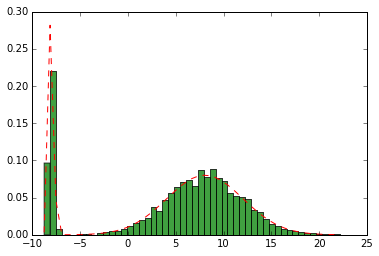

In [70]:
if __name__ == "__main__":
    unitest = Test(param = [0.2, 0.8, -8, 8, 1/4,4],n_samples=5000)
    print unitest.unitest(0.5)
    print np.var(unitest.sample1d)

In [3]:
#! /usr/bin/env python
'''
    code for gaussian mixture solver
    based on Kalai STOC'10 paper
    Efficiently learning mixtures of two gaussians
'''
from __future__ import division
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import mixture
import time
#from gmm_poly import *
%matplotlib inline 
class Test(object):
    def __init__(self, param, n_samples, seed = 1):
            self.w1 = param[0]
            self.w2 = param[1]
            self.mu1 = param[2]
            self.mu2 = param[3]
            self.sigma1 = param[4]
            self.sigma2 = param[5]
            self.n_samples = n_samples
            self.sample2d, self.sample1d  = self.sample()
            
    def sample(self, seed = 0):
        gmix = mixture.GaussianMixture(n_components=2, covariance_type='full')
        gmix.fit(np.random.rand(2,1))  # Now it thinks it is trained
        gmix.weights_ = np.array([self.w1, self.w2]) # mixture weights (n_components,) 
        gmix.means_ = np.array([[self.mu1], [self.mu2]])         # mixture means (n_components, 2) 
        gmix.covariances_ = np.array([[[self.sigma1**2]], [[self.sigma2**2]]]) # mixture cov (n_components, 2, 2)
        sample, _ = gmix.sample(self.n_samples)
        return (sample, sample.flatten())

    def unitest(self, eps, isplot = True):
        # fit a Gaussian Mixture Model with two components
        start = time.time()
        clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
        clf.fit(self.sample2d)
        end = time.time()
        t1 = (end - start)

        start = time.time()
        test = TwoGaussian(self.sample1d)
        #res = test.recoverFromMoments(eps)
        res = test.recover1DMixture(eps)
        end = time.time()
        t2 = (end - start)
        print "Skelearn GMM cost time is: {} sec. \n".format(t1)
        print "Moment method GMM cost time is: {} sec. \n".format(t2)
        param1 = self.parseGMM(clf)
        param2 = self.parseTwoGmm(res)
        if isplot:
            self.plot(param1.flatten(), param2.flatten())
        return (param1, param2)
    
    def parseGMM(self, model):
        return np.round([model.weights_.flatten(), model.means_.flatten(), np.sqrt(model.covariances_.flatten())],4)
    
    def parseTwoGmm(self, model):
        model = np.array(model)
        return np.round(model.real,4)
    def generateMixture(self, bins, param):
        assert len(param) == 6
        return param[0]*norm.pdf(bins, loc=param[2], scale=param[4])\
        +param[1]*norm.pdf(bins, loc=param[3], scale=param[5])
        
    def plot(self, param1, param2):
        n, bins, patches =plt.hist(self.sample1d, 50, normed=1, facecolor='green', alpha=0.75)
        y1 = self.generateMixture(bins, param1)
        plot1 = plt.plot(bins, y1, 'r--', linewidth=1, color = 'red')
        y2 = self.generateMixture(bins, param2)
        plot2 = plt.plot(bins, y2, 'r--', linewidth=1, color = 'blue')